# Solving the Farmer's problem

The [Farmer's Problem](https://www.math.uh.edu/~rohop/Spring_15/Chapter1.pdf) is a teaching example presented in the well-known textbook by John Birge and Francois Louveaux.

* Birge, John R., and Francois Louveaux. Introduction to stochastic programming. Springer Science & Business Media, 2011.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyomo.environ as pyo

## Problem Statement

In the [farmer's problem](https://www.math.uh.edu/~rohop/Spring_15/Chapter1.pdf), a European farmer has to allocate 500 acres of land to three different crops (wheat, corn, and sugar beets) aiming to maximize profit. 

* Planting one acre of wheat, corn and beet costs \\$150, \\$230 and \\$260, respectively.

* The mean yields are 2.5, 3.0, and 20.0 tons per acre for wheat, corn, and sugar beets, respectively. However, the yields can vary up to 25% from nominal conditions depending on weather.

* At least 200 tons of wheat and 240 tons of corn are needed for cattle feed. These can be raised on the farm or purchased from a wholesaler. 

* Over the last decade, mean selling prices have been \\$170 and \\$150 per ton of wheat and corn, respectively. The purchase prices are 40% more due to wholesaler's margins and transportation costs.

* Sugar beets are a profitable crop expected to sell at \\$36 per ton, but there is a quota on sugar beet production. Any amount in excess of the quota can be sold at only \\$10 per ton. The farmer's  quota for next year is 6,000 tons.

After collecting this data, the farmer is unsure how to allocate the land among the three crops. So the farmer has hired you as a consultant to develop a model. After interviewing the farmer, you have determined you need to present three solutions for the farmer to consider:

1. The first solution should represent the mean solution. How should the farmer allocate land to maximize profits under mean conditions.

2. The second solution should consider the potential impact of weather. How should the farmer allocate land to maximize expected profit if the yields could go up or down by 20% due to weather conditions? What is the profit under each scenario?

3. During your interview you learned the farmer needs a minimal profit each year to stay in business. How would you allocate land use to maximize the worst case profit?  

4. Determine the tradeoff between risk and return by computing the mean expected profit when the minimum required profit is the worst case found in part 3, and \\$58,000, \\$56,000, \\$54,000, \\$52,000, \\$50,000, and \\$48,000. Compare these solutions to part 2 by plotting the expected loss in profit. 

5. What would be your advice to the farmer regarding land allocation?

## Data Summary

| Scenario | Yield for wheat <br> (tons/acre)| Yield for corn <br> (tons/acre) | Yield for beets <br> (tons/acre) |
| :-- | :-: | :-: | :-: |
| Good weather | 3 | 3.6 | 24 |
| Average weather | 2.5 | 3 | 20 |
| Bad weather | 2 | 2.4 | 16 |

We first consider the case in which all the prices are fixed and not weather-dependent. The following table summarizes the data.

| Commodity | Sell <br> Price <br> (euro/ton) | Market <br> Demand <br> (tons) | Buy <br> Price <br> (euro/ton) | Cattle Feed <br> Required <br> (tons) | Planting <br> Cost <br> (euro/acre) |
| :-- | :--: | :--: | :--: | :--: | :--: |
| Wheat | 170 | - | 238 | 200 | 150 |
| Corn | 150 | - | 210 | 240 | 230 |
| Beets | 36 | 6000 | - | 0 | 260 | 6000 |
| Beets extra | 10 | - | - | 0 | 260 |


## Data Modeling

In [28]:
commodities = pd.DataFrame({
    "wheat": {"sell": 170, "buy": 238, "required": 200, "cost": 150},
    "corn": {"sell": 150,  "buy": 210, "required": 240, "cost": 230},
    "beets": {"sell": 36, "demand": 6000, "required": 0, "cost": 260},
    "more beets": {"sell": 10, "required": 0, "cost": 260},
}).T

# fill NaN with a "Big M"
M = 20000
commodities["buy"].fillna(M, inplace=True)
commodities["demand"].fillna(M, inplace=True)

display(commodities)

,sell,buy,required,cost,demand
wheat,170.0,238.0,200.0,150.0,20000.0
corn,150.0,210.0,240.0,230.0,20000.0
beets,36.0,20000.0,0.0,260.0,6000.0
more beets,10.0,20000.0,0.0,260.0,20000.0


In [29]:
yields = pd.DataFrame({
    "good":    {"wheat": 3.0, "corn": 3.6, "beets": 24, "more beets": 24},
    "average": {"wheat": 2.5, "corn": 3.0, "beets": 20, "more beets": 20},
    "poor":    {"wheat": 2.0, "corn": 2.4, "beets": 16, "more beets": 16},
}).T
display(yields)

,wheat,corn,beets,more beets
good,3.0,3.6,24.0,24.0
average,2.5,3.0,20.0,20.0
poor,2.0,2.4,16.0,16.0


## Farm Simulation

In [40]:
plant = pd.Series({"wheat": 100, "corn": 200, "beets": 200, "more beets": 0})

def sim_farm(plant, commodities, yields):
    scenarios = yields.index
    crops = commodities.index
    for s in scenarios:
        print(f"\nScenario: {s}")
        df = pd.DataFrame()
        df["plant"] = pd.Series({c: plant[c] for c in crops})
        display(df)
    return
    

display(plant)
sim_farm(plant, commodities, yields)

wheat         100
corn          200
beets         200
more beets      0
dtype: int64


Scenario: good


,plant
wheat,100
corn,200
beets,200
more beets,0



Scenario: average


,plant
wheat,100
corn,200
beets,200
more beets,0



Scenario: poor


,plant
wheat,100
corn,200
beets,200
more beets,0


## Model Building

## 1. Mean Solution

In [9]:
m = farmer(commodities, pd.DataFrame(yields.mean(), columns=["mean"]).T)

# maximize mean profit
@m.Objective(sense=pyo.maximize)
def objective(m):
    return m.mean_profit

pyo.SolverFactory('cbc').solve(m)
m.plant.dislay()

show_farmer(m)

AttributeError: 'IndexedVar' object has no attribute 'dislay'

## 2. Stochastic Solution


The problem statement asks for a number of different analyses. In a consulting situation, it is possible the client would ask more "what if" questions after hearing the initial results. For these reasons, we build a function that returns a Pyomo model the variables and expressions needed to address all parts of the problem. 

In [12]:
import pyomo.environ as pyo

def farmer(commodities, yields, total_land=500):
    
    m = pyo.ConcreteModel("Farmer's Problem")

    m.CROPS = pyo.Set(initialize=commodities.index)
    m.SCENARIOS = pyo.Set(initialize=yields.index)

    # mutable parameters
    m.total_land = pyo.Param(initialize=total_land, mutable=True)

    # here and now (first stage) decision variables
    m.plant = pyo.Var(m.CROPS, domain=pyo.NonNegativeReals, bounds=(0, m.total_land))

    # wait and see (recourse, or second stage) decision variables
    m.produce = pyo.Var(m.SCENARIOS, m.CROPS, domain=pyo.NonNegativeReals)
    m.sell = pyo.Var(m.SCENARIOS, m.CROPS, domain=pyo.NonNegativeReals)
    m.buy = pyo.Var(m.SCENARIOS, m.CROPS, domain=pyo.NonNegativeReals)
    m.worst_case_profit = pyo.Var()

    # first stage
    
    @m.Constraint()
    def limit_on_planted_land(m):
        return sum(m.plant[c] for c in m.CROPS) <= m.total_land
    
    @m.Expression(m.CROPS)
    def planting_cost(m, c):
        return m.plant[c] * commodities.loc[c, "cost"]

    # second stage constraints
    
    @m.Constraint(m.SCENARIOS, m.CROPS)
    def crops_produced(m, s, c):
        return m.produce[s, c] == yields.loc[s, c] * m.plant[c]

    @m.Constraint(m.SCENARIOS, m.CROPS)
    def buy_sell(m, s, c):
        return m.produce[s, c] + m.buy[s, c] == m.sell[s, c] + commodities.loc[c, "required"] 

    @m.Constraint(m.SCENARIOS, m.CROPS)
    def cannot_sell_more_than_demand(m, s, c):
        return m.sell[s, c] <= commodities.loc[c, "demand"]

    @m.Expression(m.SCENARIOS, m.CROPS)
    def revenue(m, s, c):
        return commodities.loc[c, "sell"] * m.sell[s, c]
    
    @m.Expression(m.SCENARIOS, m.CROPS)
    def expense(m, s, c):
        return m.planting_cost[c] + commodities.loc[c, "buy"] * m.buy[s, c] 
    
    @m.Expression(m.SCENARIOS)
    def scenario_profit(m, s):
        return sum(m.revenue[s, c] - m.expense[s, c] for c in m.CROPS)
    
    @m.Constraint(m.SCENARIOS)
    def worst_case_profit_definition(m, s):
        return m.scenario_profit[s] >= m.worst_case_profit

    @m.Expression()
    def mean_profit(m):
        return sum(m.scenario_profit[s] for s in m.SCENARIOS)/len(m.SCENARIOS)
    
    return m

def sim_farmer(plant, commodities, yields):
    retur

def show_farmer(m):
    m.scenario_profit.display()
    m.mean_profit.display()
    for s in m.SCENARIOS:
        print(f"\nScenario: {s}")
        print(f"    scenario profit = {m.scenario_profit[s]()}")
        df = pd.DataFrame()
        df["plant"] = pd.Series({c: m.plant[c]() for c in m.CROPS})
        df["produce"] = pd.Series({c: m.produce[s, c]() for c in m.CROPS})
        df["buy"] = pd.Series({c: m.buy[s, c]() for c in m.CROPS})
        df["feed"] = pd.Series({c: commodities.loc[c, "required"] for c in m.CROPS})
        df["sell"] = pd.Series({c: m.sell[s, c]() for c in m.CROPS})
        df["revenue"] = pd.Series({c: m.revenue[s, c]() for c in m.CROPS})
        df["expense"] = pd.Series({c: m.expense[s, c]() for c in m.CROPS})
        display(df)



In [11]:

m = farmer(commodities, yields)

# maximize mean profit
@m.Objective(sense=pyo.maximize)
def objective(m):
    return m.mean_profit

pyo.SolverFactory('cbc').solve(m)
m.plant.display()

show_farmer(m)

plant : Size=4, Index=CROPS
    Key        : Lower : Value : Upper : Fixed : Stale : Domain
         beets :     0 : 250.0 :   500 : False : False : NonNegativeReals
          corn :     0 :  80.0 :   500 : False : False : NonNegativeReals
    more beets :     0 :   0.0 :   500 : False : False : NonNegativeReals
         wheat :     0 : 170.0 :   500 : False : False : NonNegativeReals
scenario_profit : Size=3
    Key     : Value
    average : 109350.0
       good : 167000.0
       poor :  48820.0
mean_profit : Size=1
    Key  : Value
    None : 108390.0

Scenario: good
    scenario profit = 167000.0


,plant,produce,buy,feed,sell,revenue,expense
wheat,170.0,510.0,0.0,200,310.0,52700.0,25500.0
corn,80.0,288.0,0.0,240,48.0,7200.0,18400.0
beets,250.0,6000.0,0.0,0,6000.0,216000.0,65000.0
more beets,0.0,0.0,0.0,0,0.0,0.0,0.0



Scenario: average
    scenario profit = 109350.0


,plant,produce,buy,feed,sell,revenue,expense
wheat,170.0,425.0,0.0,200,225.0,38250.0,25500.0
corn,80.0,240.0,0.0,240,0.0,0.0,18400.0
beets,250.0,5000.0,0.0,0,5000.0,180000.0,65000.0
more beets,0.0,0.0,0.0,0,0.0,0.0,0.0



Scenario: poor
    scenario profit = 48820.0


,plant,produce,buy,feed,sell,revenue,expense
wheat,170.0,340.0,0.0,200,140.0,23800.0,25500.0
corn,80.0,192.0,48.0,240,0.0,0.0,28480.0
beets,250.0,4000.0,0.0,0,4000.0,144000.0,65000.0
more beets,0.0,0.0,0.0,0,0.0,0.0,0.0


## 3. Worst Case Profit

In [89]:
m = farmer(commodities, yields)

# maximize mean profit
@m.Objective(sense=pyo.maximize)
def objective(m):
    return m.worst_case_profit

pyo.SolverFactory('cbc').solve(m)

show_farmer(m)

scenario_profit : Size=3
    Key     : Value
    average : 108250.0
       good : 166000.0
       poor :  50500.0
mean_profit : Size=1
    Key  : Value
    None : 108250.0

Scenario: good
    scenario profit = 166000.0


,plant,produce,buy,feed,sell,revenue,expense
wheat,150.0,450.0,0.0,200,250.0,42500.0,22500.0
corn,100.0,360.0,0.0,240,120.0,18000.0,23000.0
beets,250.0,6000.0,0.0,0,6000.0,216000.0,65000.0
more beets,0.0,0.0,0.0,0,0.0,0.0,0.0



Scenario: average
    scenario profit = 108250.0


,plant,produce,buy,feed,sell,revenue,expense
wheat,150.0,375.0,0.0,200,175.0,29750.0,22500.0
corn,100.0,300.0,0.0,240,60.0,9000.0,23000.0
beets,250.0,5000.0,0.0,0,5000.0,180000.0,65000.0
more beets,0.0,0.0,0.0,0,0.0,0.0,0.0



Scenario: poor
    scenario profit = 50500.0


,plant,produce,buy,feed,sell,revenue,expense
wheat,150.0,300.0,0.0,200,100.0,17000.0,22500.0
corn,100.0,240.0,0.0,240,0.0,0.0,23000.0
beets,250.0,4000.0,0.0,0,4000.0,144000.0,65000.0
more beets,0.0,0.0,0.0,0,0.0,0.0,0.0


## 4. Risk versus Return

<AxesSubplot:xlabel='wc'>

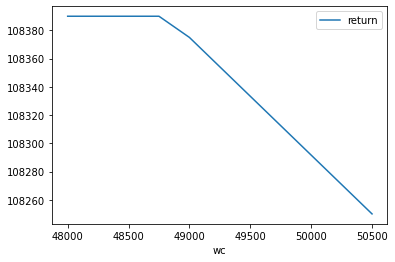

In [64]:
df = pd.DataFrame()

for wc in np.linspace(48000, 50500, 11):
    m = farmer(commodities, yields)
    
    @m.Constraint(m.CROPS)
    def min_profit(m, c):
        return m.scenario_profit[s] >= wc

    # maximize mean profit
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return m.mean_profit

    pyo.SolverFactory('cbc').solve(m)
    
    df.loc[wc, "return"] = m.mean_profit()
    df.loc[wc, "wc"] = wc
    
df.plot(x="wc", y="return")